# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.402146,False,-2.260764
1,0.565567,False,-0.861916
2,-0.571972,True,5.746390
3,0.048141,True,3.893462
4,0.117402,False,0.624751
...,...,...,...
995,-0.647364,False,0.393974
996,-0.484294,False,-0.559209
997,0.072056,True,5.555845
998,-2.243040,True,3.731485


<Axes: xlabel='v0'>

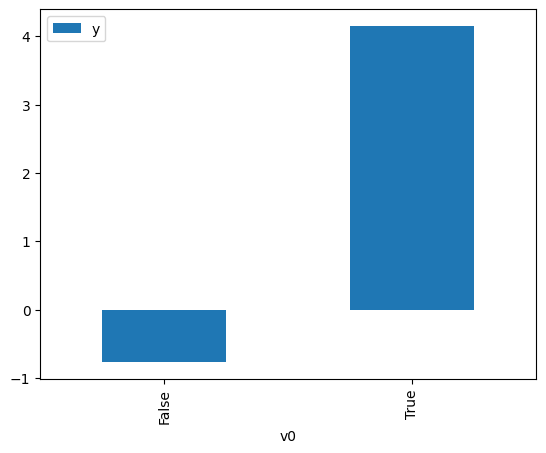

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

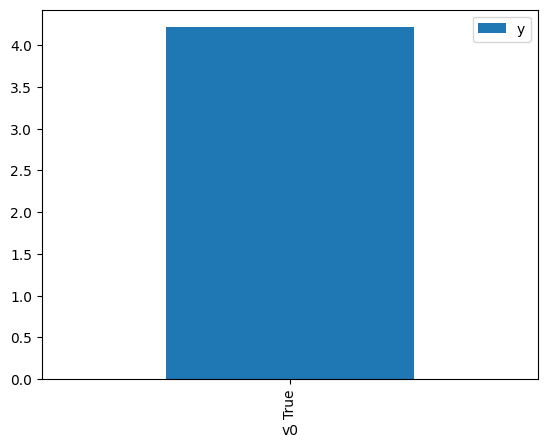

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.604470,False,-1.066171,0.803883,1.243962
1,-1.764266,False,0.033907,0.825890,1.210815
2,-1.917766,False,-0.587338,0.845149,1.183223
3,-1.067304,False,-0.484437,0.715012,1.398578
4,1.065218,False,1.274545,0.263285,3.798167
...,...,...,...,...,...
995,-1.194951,False,-1.182236,0.738175,1.354693
996,-0.912003,False,-0.175941,0.685234,1.459356
997,-1.101601,False,-0.836830,0.721355,1.386279
998,-1.514791,False,-0.454329,0.790641,1.264797


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.391842,True,5.158125,0.424927,2.353343
1,-1.261700,True,2.987902,0.250208,3.996671
2,-0.645624,True,3.196358,0.369468,2.706591
3,-1.243338,True,1.545910,0.253370,3.946805
4,0.050677,True,7.452294,0.525433,1.903191
...,...,...,...,...,...
995,-1.499040,True,1.713567,0.211752,4.722504
996,-1.397529,True,4.695231,0.227650,4.392715
997,-0.377572,True,5.143570,0.428117,2.335810
998,-0.979914,True,4.543024,0.301537,3.316345


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.909
Model:                            OLS   Adj. R-squared (uncentered):              0.908
Method:                 Least Squares   F-statistic:                              4963.
Date:                Fri, 14 Jul 2023   Prob (F-statistic):                        0.00
Time:                        01:17:35   Log-Likelihood:                         -1398.0
No. Observations:                1000   AIC:                                      2800.
Df Residuals:                     998   BIC:                                      2810.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9862      0.024     40.650      0.000       0.939       1.034
x2             4.9656      0.052     95.537      0.000       4.864       5.068
==============================================================================
Omnibus:                        6.199   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                4.896
Skew:                           0.066   Prob(JB):                       0.0864
Kurtosis:                       2.684   Cond. No.                         2.17
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""